# Jobs and Salaries Text Analysis Project
## Econ 1680: MLTA and Econ
#### Name: Lena Kim

It is a known fact that many companies receive thousand and thousands of job applications
a day, and as such rely on algorithms to screen resumes. In fact, a New York Times coverage of the ever-increasing 
reliance on resume algorithms has even led to the identification
of keywords and skills to include in your resume to make it past this resume sifter (Weed
(2021)). As a Post article states, including even one of these key words can mean the differ-
ence between getting hired and being discarded (Abril (2023).

Taking inspiration from this trend, I want to accurately predict the salary levels of a job
based on keywords used in its job description, as well as the resumes that it gets. With
some companies remaining tight-lipped in regards to salary transparency, this text analysis
project may be useful for job seekers who want to know more about compensation before
taking any steps toward subjecting themselves to a cold, algorithmic hiring process.

Research Question: Using keywords and skills in the job description, can we accurately
predict the salary of the job?


# This notebook focuses on Methods

In [1]:
#for general and EDA:
import requests
from pprint import pprint
import pandas as pd
import time
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import regex as re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#for preprocessing:
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from langdetect import detect
#for regressions:
from transformers import pipeline
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#for neural net:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import RidgeCV


# Read in cleaned csv file from preprocessing step:

In [2]:
indeed_jobs = pd.read_csv('data/clean_indeed_jobs.csv')

In [3]:
indeed_jobs.head()

,company,companyInfo/companyDescription,companyInfo/companyLogo,companyInfo/indeedUrl,companyInfo/rating,companyInfo/reviewCount,companyInfo/url,description,descriptionHTML,externalApplyLink,...,searchInput/location,url,clean description,stemmed_description,lemmatized_description,sentiment,sentiment_vader,binary sentiment,logitlasso predicted sentiment,yearly_salary
0,Maximus,"As a well-respected government contractor, we’...",https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Maximus-1,3.5,7644.0,https://maximus.com,"Every day, Customer Service Representatives (C...","<p>Every day, Customer Service Representatives...",NaN,...,New York,https://www.indeed.com/rc/clk?jk=fb57ed7bb664b...,every day customer service representatives (cs...,"everi day , custom servic repres ( csr ) at ma...","Every day , Customer Service Representatives (...",positive,positive,1.0,1.0,39500.0
1,AIG,AIG and its member companies form one of the w...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/AIG,3.7,4517.0,http://www.aig.com,Underwriter Technician \n\n This Underwriter r...,Underwriter Technician \n<br>\n<br> This Under...,https://aig.wd1.myworkdayjobs.com/en-US/aig/jo...,...,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,underwriter technician this underwriter rol...,underwrit technician thi underwrit role will b...,Underwriter Technician This Underwriter role w...,positive,positive,1.0,1.0,60500.0
2,UnitedHealthcare,At UnitedHealthcare we’re dedicated to helping...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Unitedhealthcare,3.7,2449.0,http://www.uhc.com/,If you are located within the state of New Yor...,<div>\n <p><b>If you are located within the st...,https://careers.unitedhealthgroup.com/job/2015...,...,New York,https://www.indeed.com/rc/clk?jk=4827d1f6ae094...,if you are located within the state of new yor...,if you are locat within the state of new york ...,If you are located within the state of New Yor...,positive,positive,1.0,1.0,32000.0
3,AAA Northeast,AAA Northeast is one of the largest and most i...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Aaa-Northeast,3.4,401.0,http://northeast.aaa.com,Eligible applicants must live within the AAA N...,<div>\n <p>Eligible applicants must live withi...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,New York,https://www.indeed.com/rc/clk?jk=f721fe2d368ea...,eligible applicants must live within the aaa n...,elig applic must live within the aaa northeast...,Eligible applicant must live within the AAA No...,positive,positive,1.0,1.0,37000.0
4,Marram Montauk,NaN,NaN,https://www.indeed.com/cmp/Society-Caf%C3%A9--...,NaN,NaN,NaN,ABOUT OUR COMPANYMarram Montauk is located on ...,<p><b>ABOUT OUR COMPANY</b><br>Marram Montauk ...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,about our companymarram montauk is located on ...,about our companymarram montauk is locat on th...,ABOUT OUR COMPANYMarram Montauk is located on ...,positive,positive,1.0,1.0,160000.0


# Analysis: Sentiment Analysis

In [4]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_and_lemmatize(text): #function to stem and lemmatize
    words = word_tokenize(text)
    
    #stem and lemmatize each word:
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    #join back stemmed and lemmatized words
    stemmed_text = ' '.join(stemmed_words)
    lemmatized_text = ' '.join(lemmatized_words)
    
    return stemmed_text, lemmatized_text

#create two new cols for stemmed and lemmatized descriptions:
indeed_jobs['stemmed_description'], indeed_jobs['lemmatized_description'] = zip(*indeed_jobs['description'].map(stem_and_lemmatize))


In [5]:
#use lemmatized words for term frequencies, as it is more readable than stemmed:
vectorizer = TfidfVectorizer() #initialize vectorizer for get_feature_names_out 
X = vectorizer.fit_transform(indeed_jobs['lemmatized_description'])
X.shape

(639, 12497)

In [6]:
features = vectorizer.get_feature_names_out() #word features 
#now we create a cosine similarity matrix to measure similarities between job descriptions:
cos_sim_matrix = cosine_similarity(X) 
df_cossim = pd.DataFrame(cos_sim_matrix)
df_cossim.head()

#create a readable dataframe of similarity values:
df_cossim_tri = pd.DataFrame(np.tril(df_cossim.values, k=-1))
df_rank = df_cossim_tri.unstack().reset_index()
df_rank.columns = ['row', 'column', 'similarity']

similarity_table = df_rank.sort_values(by = 'similarity', ascending = False).head(5)
similarity_table['description_row'] = [indeed_jobs['lemmatized_description'][row] for row in similarity_table['row']] #actual description for row index
similarity_table['description_col'] = [indeed_jobs['lemmatized_description'][col] for col in similarity_table['column']] #actual description for col index
similarity_table


,row,column,similarity,description_row,description_col
148736,232,488,0.908626,Simon & Schuster ha been named to Forbes magaz...,Simon & Schuster wa named to Forbes magazine l...
91856,143,479,0.887318,About Gap Inc. Our brand bridge the gap we see...,About Gap Inc. Our brand bridge the gap we see...
39819,62,201,0.883194,Additional Information Bourbon Steak New York ...,Job Number 24048887 Job Category Engineering &...
39851,62,233,0.873010,Additional Information Bourbon Steak New York ...,Additional Information Pay : $ 32.13- $ 42.84/...
128672,201,233,0.865514,Job Number 24048887 Job Category Engineering &...,Additional Information Pay : $ 32.13- $ 42.84/...


We can see that the most similar descriptions are from job descriptions that open first with the company description. Certain companies seem to open with this practice throughout their various jobs, which makes sense. 

# Sentiment Analysis
TextBlob pretrained model to label sentiments: I expect that since these are job advertisements, most will be positive or neutral. 

(Hugging Face Library fails to execute on my computer)

In [7]:
from textblob import TextBlob

#function to perform pretrained sentiment analysis and label
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

#apply sentiment analysis to each description:
indeed_jobs['sentiment'] = indeed_jobs['clean description'].apply(get_sentiment)

indeed_jobs.head()

,company,companyInfo/companyDescription,companyInfo/companyLogo,companyInfo/indeedUrl,companyInfo/rating,companyInfo/reviewCount,companyInfo/url,description,descriptionHTML,externalApplyLink,...,searchInput/location,url,clean description,stemmed_description,lemmatized_description,sentiment,sentiment_vader,binary sentiment,logitlasso predicted sentiment,yearly_salary
0,Maximus,"As a well-respected government contractor, we’...",https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Maximus-1,3.5,7644.0,https://maximus.com,"Every day, Customer Service Representatives (C...","<p>Every day, Customer Service Representatives...",NaN,...,New York,https://www.indeed.com/rc/clk?jk=fb57ed7bb664b...,every day customer service representatives (cs...,"everi day , custom servic repres ( csr ) at ma...","Every day , Customer Service Representatives (...",positive,positive,1.0,1.0,39500.0
1,AIG,AIG and its member companies form one of the w...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/AIG,3.7,4517.0,http://www.aig.com,Underwriter Technician \n\n This Underwriter r...,Underwriter Technician \n<br>\n<br> This Under...,https://aig.wd1.myworkdayjobs.com/en-US/aig/jo...,...,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,underwriter technician this underwriter rol...,underwrit technician thi underwrit role will b...,Underwriter Technician This Underwriter role w...,positive,positive,1.0,1.0,60500.0
2,UnitedHealthcare,At UnitedHealthcare we’re dedicated to helping...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Unitedhealthcare,3.7,2449.0,http://www.uhc.com/,If you are located within the state of New Yor...,<div>\n <p><b>If you are located within the st...,https://careers.unitedhealthgroup.com/job/2015...,...,New York,https://www.indeed.com/rc/clk?jk=4827d1f6ae094...,if you are located within the state of new yor...,if you are locat within the state of new york ...,If you are located within the state of New Yor...,positive,positive,1.0,1.0,32000.0
3,AAA Northeast,AAA Northeast is one of the largest and most i...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Aaa-Northeast,3.4,401.0,http://northeast.aaa.com,Eligible applicants must live within the AAA N...,<div>\n <p>Eligible applicants must live withi...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,New York,https://www.indeed.com/rc/clk?jk=f721fe2d368ea...,eligible applicants must live within the aaa n...,elig applic must live within the aaa northeast...,Eligible applicant must live within the AAA No...,positive,positive,1.0,1.0,37000.0
4,Marram Montauk,NaN,NaN,https://www.indeed.com/cmp/Society-Caf%C3%A9--...,NaN,NaN,NaN,ABOUT OUR COMPANYMarram Montauk is located on ...,<p><b>ABOUT OUR COMPANY</b><br>Marram Montauk ...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,about our companymarram montauk is located on ...,about our companymarram montauk is locat on th...,ABOUT OUR COMPANYMarram Montauk is located on ...,positive,positive,1.0,1.0,160000.0


In [8]:
indeed_jobs[indeed_jobs['sentiment'] == 'negative'].iloc[0]['clean description']


'the day starts with cleaning our office cleaning a small rooming house cleaning common areas in residential homes and cleaning apartment turn overs all cleaning within 1 mile of office at 500 westcott street job type: part-time pay: $17.00 per hour expected hours: no less than 20 per week schedule:   4 hour shift  monday to friday  supplemental pay types:   bonus opportunities  work location: multiple locations'

In [9]:
indeed_jobs['sentiment'].value_counts()

sentiment
positive    624
negative     13
neutral       2
Name: count, dtype: int64

## Applying another pretrained model: Binary classification

In [10]:

sia = SentimentIntensityAnalyzer() #initialize

#function to perform vader sentiment analysis
def get_sentiment_vader(text):
    #calculate sentiment scores
    scores = sia.polarity_scores(text)
    #classify as positive if compound score is greater than 0, otherwise negative
    if scores['compound'] >= 0:
        return 'positive'
    else:
        return 'negative'

#apply sentiment analysis and labeling using VADER to each description
indeed_jobs['sentiment_vader'] = indeed_jobs['clean description'].apply(get_sentiment_vader)
indeed_jobs.head()

,company,companyInfo/companyDescription,companyInfo/companyLogo,companyInfo/indeedUrl,companyInfo/rating,companyInfo/reviewCount,companyInfo/url,description,descriptionHTML,externalApplyLink,...,searchInput/location,url,clean description,stemmed_description,lemmatized_description,sentiment,sentiment_vader,binary sentiment,logitlasso predicted sentiment,yearly_salary
0,Maximus,"As a well-respected government contractor, we’...",https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Maximus-1,3.5,7644.0,https://maximus.com,"Every day, Customer Service Representatives (C...","<p>Every day, Customer Service Representatives...",NaN,...,New York,https://www.indeed.com/rc/clk?jk=fb57ed7bb664b...,every day customer service representatives (cs...,"everi day , custom servic repres ( csr ) at ma...","Every day , Customer Service Representatives (...",positive,positive,1.0,1.0,39500.0
1,AIG,AIG and its member companies form one of the w...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/AIG,3.7,4517.0,http://www.aig.com,Underwriter Technician \n\n This Underwriter r...,Underwriter Technician \n<br>\n<br> This Under...,https://aig.wd1.myworkdayjobs.com/en-US/aig/jo...,...,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,underwriter technician this underwriter rol...,underwrit technician thi underwrit role will b...,Underwriter Technician This Underwriter role w...,positive,positive,1.0,1.0,60500.0
2,UnitedHealthcare,At UnitedHealthcare we’re dedicated to helping...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Unitedhealthcare,3.7,2449.0,http://www.uhc.com/,If you are located within the state of New Yor...,<div>\n <p><b>If you are located within the st...,https://careers.unitedhealthgroup.com/job/2015...,...,New York,https://www.indeed.com/rc/clk?jk=4827d1f6ae094...,if you are located within the state of new yor...,if you are locat within the state of new york ...,If you are located within the state of New Yor...,positive,positive,1.0,1.0,32000.0
3,AAA Northeast,AAA Northeast is one of the largest and most i...,https://d2q79iu7y748jz.cloudfront.net/s/_squar...,https://www.indeed.com/cmp/Aaa-Northeast,3.4,401.0,http://northeast.aaa.com,Eligible applicants must live within the AAA N...,<div>\n <p>Eligible applicants must live withi...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,New York,https://www.indeed.com/rc/clk?jk=f721fe2d368ea...,eligible applicants must live within the aaa n...,elig applic must live within the aaa northeast...,Eligible applicant must live within the AAA No...,positive,positive,1.0,1.0,37000.0
4,Marram Montauk,NaN,NaN,https://www.indeed.com/cmp/Society-Caf%C3%A9--...,NaN,NaN,NaN,ABOUT OUR COMPANYMarram Montauk is located on ...,<p><b>ABOUT OUR COMPANY</b><br>Marram Montauk ...,https://www.paycomonline.net/v4/ats/web.php/jo...,...,New York,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,about our companymarram montauk is located on ...,about our companymarram montauk is locat on th...,ABOUT OUR COMPANYMarram Montauk is located on ...,positive,positive,1.0,1.0,160000.0


In [11]:
indeed_jobs['sentiment_vader'].value_counts()

sentiment_vader
positive    636
negative      3
Name: count, dtype: int64

## Logit-Lasso to predict sentiments:

In [12]:
indeed_jobs.loc[((indeed_jobs['sentiment_vader'] == "negative")), 'binary sentiment'] = 0 #negatives are 0
indeed_jobs.loc[((indeed_jobs['sentiment_vader'] == "positive")), 'binary sentiment'] = 1 #positives are 1

In [13]:
x = X.toarray() #doc term matrix to array
y = indeed_jobs['binary sentiment'].to_numpy() #target variable:sentiment


#split the training and testing datasets:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)


C = [0.001, 0.01, 0.1, 1, 10, 100, 1000] #hyperparams

best_accuracy = 0
best_c = None

for c in C:
    model = LogisticRegression(penalty='l1', solver='liblinear', C = c, random_state = 1680) #initialize logreg with c
    
    model.fit(x_train, y_train) #fit data first
    current_accuracy = model.score(x_test, y_test) #get the prediction accuracy for testing set
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy #replace with better accuracy
        best_c = c #replace with current c value

#print results after all the loops
print('best accuracy score', best_accuracy)
print('best c parameter', best_c) 


best accuracy score 0.984375
best c parameter 0.01


### Which words predict the class?


In [14]:
coefs = model.coef_ 
df_coef = pd.DataFrame({'word': features, 'coef': coefs[-1].tolist()}) #converts words (from feature matrix) and coefficients of logreg into
#one dataframe 
df_coef['abs coef']= df_coef['coef'].abs() #converts those coefficients into absolute value and stores in a column called abs coef
indeed_jobs['logitlasso predicted sentiment'] = model.predict(x) #calls predict with doc term matrix and adds model's prediction into new column
#called logitlasso predicted sentiment

In [15]:
df_coef_sorted_abs = df_coef.sort_values(by='abs coef', ascending=False).head(5) 
df_coef_sorted_abs

,word,coef,abs coef
8148,osi,-30.963059,30.963059
11411,toiletry,-23.447377,23.447377
3861,dishwashing,-21.384278,21.384278
6903,linens,-19.405892,19.405892
6435,ironing,-7.661715,7.661715


### Finding: Housekeeping words seem to be negative

# Main Research Question: 
# What words in the job description are predictive of salary?

In [16]:
indeed_jobs.columns

Index(['company', 'companyInfo/companyDescription', 'companyInfo/companyLogo',
       'companyInfo/indeedUrl', 'companyInfo/rating',
       'companyInfo/reviewCount', 'companyInfo/url', 'description',
       'descriptionHTML', 'externalApplyLink', 'id', 'isExpired', 'jobType',
       'jobType/0', 'jobType/1', 'jobType/2', 'jobType/3', 'location',
       'positionName', 'postedAt', 'postingDateParsed', 'rating',
       'reviewsCount', 'salary', 'scrapedAt', 'searchInput/country',
       'searchInput/location', 'url', 'clean description',
       'stemmed_description', 'lemmatized_description', 'sentiment',
       'sentiment_vader', 'binary sentiment', 'logitlasso predicted sentiment',
       'yearly_salary'],
      dtype='object')

## Split to X (tfidf measures) and y (yearly salary)

In [17]:
#split the data into features and target variable
indeed_jobs= indeed_jobs.dropna(subset=['yearly_salary']).copy()

X = indeed_jobs['clean description']
y = indeed_jobs['yearly_salary']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


## Perform ridge regression looping over for best alpha

In [23]:
#alphas_ridge = np.linspace(1e-6, 1, num=50)
alphas_ridge = np.linspace(0.001, 5, num=50)
#initialize lists to store mean prediction errors and coefficients
cv_errs_r = []
coefs_r = []
#Define MSE fitted to our jobs dataset (initial set of MSE_r = 10 was not appropriate)
initial_MSE_ridge = RidgeCV(alphas=[alpha_r], cv=5)
initial_MSE_ridge.fit(X_train_tfidf, y_train)
intial_y_pred = initial_MSE_ridge.predict(X_test_tfidf)
MSE_r = mean_squared_error(y_test, intial_y_pred)

bestalpha_r = 0

#loop over different values of alpha
for alpha_r in alphas_ridge:
    #define Ridge regression model with cross-validation
    ridgeReg = RidgeCV(alphas=[alpha_r], cv=5)
    #ridgeReg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha= a * X_train.shape[0]))
    #fit the model
    ridgeReg.fit(X_train_tfidf, y_train)
    
    #obtain predicted values
    y_pred = ridgeReg.predict(X_test_tfidf)
    
    #compute mean squared error
    cv_errs_r.append(mean_squared_error(y_test, y_pred))
    
    #store coefficients
    coefs_r.append(ridgeReg.coef_)
    
    #update best alpha
    if mean_squared_error(y_test, y_pred) < MSE_r:
        MSE_r = mean_squared_error(y_test, y_pred)
        bestalpha_r = alpha_r

print("Best alpha:", bestalpha_r)
    
#create DataFrame to store coefficients
coefs_r = pd.DataFrame(coefs_r, columns=vectorizer.get_feature_names_out())
coefs_r.set_index(alphas_ridge, inplace=True)

Best alpha: 0.3070612244897959


Text(0, 0.5, 'CV errors')

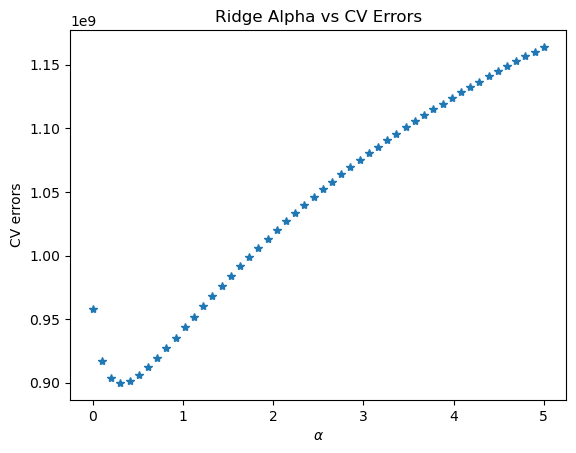

In [24]:
plt.plot(alphas_ridge, cv_errs_r, '*')
plt.title('Ridge Alpha vs CV Errors')
plt.xlabel(r'$\alpha$')
plt.ylabel('CV errors')

## Put coefficients into a table

In [25]:
coef_comp = pd.DataFrame({'var': vectorizer.get_feature_names_out(), 'var_ridge': ridgeReg.coef_})

coef_comp

,var,var_ridge
0,00,-3558.151875
1,000,27602.058052
2,0000,17.402536
3,00000754,120.185765
4,00a,-378.382623
...,...,...
12072,zoom,35.735065
12073,zpi,-139.713505
12074,zr,505.152290
12075,zulawski,-62.500153


## Focus on highest magnitude coefficients

In [26]:
coef_comp_sorted = coef_comp.reindex(coef_comp['var_ridge'].abs().sort_values(ascending=False).index)

#display top predictive words
top_predictive_words = coef_comp_sorted.head(25)
print(top_predictive_words)

                var     var_ridge
1111            and  34942.664524
1               000  27602.058052
877     advisortree  25646.176435
9894     settlement  19234.632326
12049           you  19078.421417
6867     management  19025.781729
954              ai  17078.131791
9952          shift -16359.918868
5947           info  15680.692006
1145      anthropic  15285.377074
6527           lead  14754.615668
9498           risk  14516.375279
5638           hour -13543.910505
3556        develop  13526.747383
7367           must -13073.772226
2697   compensation  13008.824596
3248       customer -12897.677279
2011       business  12824.403413
9314       research  12158.195567
1844           boss  12153.801624
7667             of  12092.344938
11794            we  11831.445640
11117       trading  11814.845501
6872       managing  11789.682603
4314         equity  11575.060667


### Top ten negative words

In [27]:
top_negative_words = coef_comp_sorted[coef_comp_sorted['var_ridge'] < 0].head(10)
top_negative_words


,var,var_ridge
9952,shift,-16359.918868
5638,hour,-13543.910505
7367,must,-13073.772226
3248,customer,-12897.677279
5346,guests,-10931.255592
3949,duties,-10929.621474
9302,required,-10511.365903
9876,service,-10131.617852
11816,week,-10062.748386
643,able,-9919.959307


### Top 20 positive words

In [28]:
top_positive_words = coef_comp_sorted[coef_comp_sorted['var_ridge'] > 0].head(20)
top_positive_words

,var,var_ridge
1111,and,34942.664524
1,000,27602.058052
877,advisortree,25646.176435
9894,settlement,19234.632326
12049,you,19078.421417
6867,management,19025.781729
954,ai,17078.131791
5947,info,15680.692006
1145,anthropic,15285.377074
6527,lead,14754.615668


# Let's do a Neural Network
Neural networks may be more effective for capturing complex relationships like our tfidf vector input variable and job salary target variable

In [49]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()


#define the neural net, with relu activation function and 64 layers, with input shape equal to number of features in our tfidf X:
model = Sequential()
model.add(Dense(64, input_shape=(X_train_tfidf.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_dense, y_train, epochs=10, batch_size=32, validation_data=(X_test_dense, y_test))
loss = model.evaluate(X_test_dense, y_test)


Epoch 1/10
16/16 [==============================] - 0s 7ms/step - loss: 7149212672.0000 - val_loss: 6220712448.0000
Epoch 2/10
16/16 [==============================] - 0s 4ms/step - loss: 7149058560.0000 - val_loss: 6220498944.0000
Epoch 3/10
16/16 [==============================] - 0s 4ms/step - loss: 7148752896.0000 - val_loss: 6220088320.0000
Epoch 4/10
16/16 [==============================] - 0s 5ms/step - loss: 7148203520.0000 - val_loss: 6219381248.0000
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - loss: 7147286016.0000 - val_loss: 6218231296.0000
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 7145814016.0000 - val_loss: 6216467968.0000
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 7143626752.0000 - val_loss: 6213886976.0000
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 7140533760.0000 - val_loss: 6210344448.0000
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 

In [50]:
#Let's inspect the weights learned by our neural net:
weights = model.layers[0].get_weights()[0] #just the first layer's weights for now
feature_names = vectorizer.get_feature_names_out()
weights_df = pd.DataFrame(weights.T, columns=feature_names)
weights_df.head()
#seems like none of the weights are too strong

,00,000,0000,00000754,00a,00am,00p,00pm,01,010,...,zoladz,zone,zones,zoo,zoology,zoom,zpi,zr,zulawski,ámbitious
0,-0.023080,0.002213,-0.012560,0.001004,-0.013717,0.008340,-0.010206,0.013018,0.009138,-0.014629,...,0.007584,-0.002764,-0.019629,-0.011565,-0.007337,-0.000210,0.007001,0.004792,-0.011291,-0.016287
1,0.210036,0.192448,0.061588,0.057856,0.038675,0.119783,0.032064,0.128774,0.114531,0.042171,...,0.032535,0.072066,0.100726,0.032648,0.072078,0.070875,0.050272,0.036625,0.054237,0.051402
2,0.005271,-0.024326,-0.017707,-0.008007,-0.015891,0.001677,0.019923,0.020134,0.003778,-0.013898,...,-0.006348,0.003127,0.013294,0.007777,-0.014184,0.014840,-0.003804,-0.020525,0.002876,0.003213
3,0.213233,0.226833,0.073793,0.050992,0.063936,0.145941,0.053858,0.121375,0.129518,0.075184,...,0.047247,0.082227,0.080809,0.039502,0.072640,0.100848,0.047810,0.047455,0.037216,0.063307
4,0.166649,0.155294,0.047559,0.020243,0.021843,0.083017,0.035435,0.104144,0.086800,0.054900,...,0.020735,0.049613,0.086328,0.041174,0.076393,0.050349,0.050074,0.035867,0.022314,0.027247


## See what words have the most weight:

In [51]:
weights = model.layers[0].get_weights()[0]

#create a DataFrame with weights and feature names
feature_names = vectorizer.get_feature_names_out()
weights_df = pd.DataFrame(weights.T, columns=feature_names)

#filter the DataFrame to get the top positive-weighted features
top_positive_words = weights_df[weights_df > 0].mean().sort_values(ascending=False).head(10)

print("Top positive-weighted features:")
print(top_positive_words)

Top positive-weighted features:
work          0.208629
high          0.207201
in            0.205372
under         0.199676
all           0.199068
to            0.198053
are           0.197803
range         0.197738
job           0.196937
experience    0.196663
dtype: float32


In [53]:
weights = model.layers[0].get_weights()[0]

#create a DataFrame with weights and feature names
feature_names = vectorizer.get_feature_names_out()
weights_df = pd.DataFrame(weights.T, columns=feature_names)

#filter the DataFrame to get the top positive-weighted features
top_neg_words = weights_df[weights_df < 0].mean().sort_values(ascending=True).head(10)

print("Top negative-weighted features:")
print(top_neg_words)

Top negative-weighted features:
schedule      -0.021709
customers     -0.021142
also          -0.020866
success       -0.020841
cultural      -0.020747
suppliers     -0.020348
yourself      -0.020332
additional    -0.020153
information   -0.020088
regulations   -0.020086
dtype: float32


### It seems like the neural network is not as great as gleaning which "skill" words are important